# demo notebook for rfft N1 calcs



In [1]:
import numpy as np
import pylab as pl
import lensitbiases as lb
from lensitbiases import n0_fft, n1_fft, utils_n1
from scipy.interpolate import UnivariateSpline as spl

%matplotlib inline

cls_unl, cls_len, cls_grad = lb.get_default_cls() # default CMB cls (put here the one you are using)

Text(0.5, 1.0, 'normalized QE $N^{(1)}$')

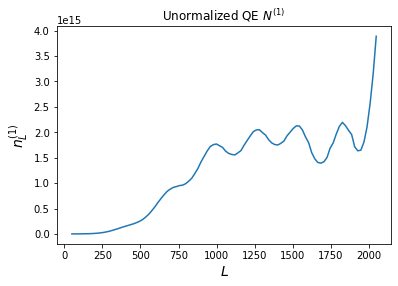

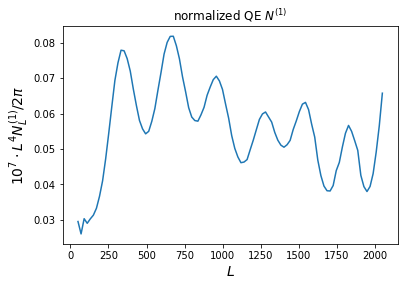

In [2]:
# planck TT N1:

lminbox = 50 # We will 2D flat-sky boxes of size such that this is the lowest multipole represented in the box (execution time is very sensitive to this and increase with lower lminbox everything else the same)


# We use CMB multipoles between lmin_ivf and lmax_ivf:  (ivf is short for 'inverse-variance filter')
lmin_ivf, lmax_ivf = 100, 2048

# noise levels (or noise spectra) used for the filtering (data noise is irrelevant for N1, which is a signal term)
nlevt = 35.    # in uK amin
nlevp = 55.    # in uK amin

# To feed in non-white noise, give an array of size lmax_ivf + 1 instead (still in uK amin) giving the noise for each multipole. The above is equivalent to

#nlevt = 35. * np.ones(lmax_ivf + 1)   
#nlevp = 55. * np.ones(lmax_ivf + 1)

beam = 5. # FWHM in arcmin. It is also possible to feed in an array instead with the full transfer function, of size lmax_ivf + 1.


# N1 depends on the relation between the filtered and CMB maps (fal matrix):
fal = utils_n1.get_fal(clscmb_filt=cls_len, clscmb_dat=cls_len, 
                       lmin_ivf=lmin_ivf, lmax_ivf=lmax_ivf, nlevt=nlevt, nlevp=nlevp, beam=beam, jt_tp=False)[1]
fal['ee'] *= 0 # using T only
fal['bb'] *= 0 # using T only

if 'te' in fal.keys(): 
    fal['te'] *= 0.

# Building (unnormalized estimate) N1 on a grid of 50 points
lib_n1 = n1_fft.n1_fft(fal, cls_len, cls_grad, cls_unl['pp'], lminbox=lminbox, lmaxbox=2500) 
Ls_n1 = np.linspace(lminbox, 2048, 100)
n1_PLlike = np.array([lib_n1.get_n1('ptt', L, do_n1mat=False) for L in Ls_n1])

pl.plot(Ls_n1, n1_PLlike)
pl.xlabel(r'$L$', fontsize=14)
pl.ylabel(r'$n_L^{(1)}$', fontsize=14)
pl.title(r'Unormalized QE $N^{(1)}$')


# the normalization should be the same as the one used in ones' analysis. Here's one way to get it with this package
(R_gg, R_cc), Ls_r = n0_fft.nhl_fft(fal, cls_grad, lminbox=lminbox, lmaxbox=4000).get_nhl('ptt')  # gradient and curl responses, and multipoles

pl.figure()
pl.plot(Ls_n1, Ls_n1 ** 2 * (Ls_n1 + 1) ** 2 * n1_PLlike / spl(Ls_r, R_gg, k=2, s=0, ext='zeros')(Ls_n1) ** 2 * 1e7 / 2. / np.pi)
pl.xlabel(r'$L$', fontsize=14)
pl.ylabel(r'$10^7\cdot L^4 N_L^{(1)} /2\pi$', fontsize=14)
pl.title(r'normalized QE $N^{(1)}$')

In [ ]:
# S4 polarization N1:
lminbox=14
# N1 depends on the relation between the filtered and CMB maps (fal matrix):
fal = utils_n1.get_fal(clscmb_filt=cls_len, clscmb_dat=cls_len, 
                       lmin_ivf=30, lmax_ivf=3000, nlevt=1. * np.ones(3001), nlevp=1. * np.sqrt(2.) * np.ones(3001), beam=1., jt_tp=False)[1]
fal['tt'] *= 0 # using polarization only
if 'te' in fal.keys(): fal['te'] *= 0.


# Building (unnormalized estimate) N1 on a grid of 50 points
lib_n1 = n1_fft.n1_fft(fal, cls_len, cls_grad, cls_unl['pp'], lminbox=lminbox, lmaxbox=4000, k2l='lensit') 
Ls_n1 = np.linspace(lminbox, 3000, 25)
n1_s4like = np.array([lib_n1.get_n1('p_p', L, do_n1mat=False) for L in Ls_n1])

pl.plot(Ls_n1, n1_s4like)
pl.xlabel(r'$L$', fontsize=14)
pl.ylabel(r'$n_L^{(1)}$', fontsize=14)
pl.title(r'Unormalized QE $N^{(1)}$')


# the normalization should be the same as the one used in ones' analysis. Here's one way to get it with this package
(R_gg, R_cc), Ls_r = n0_fft.nhl_fft(fal, cls_grad, lminbox=lminbox, lmaxbox=6000, k2l='lensit').get_nhl('p_p')  # gradient and curl responses, and multipoles

pl.figure()
pl.plot(Ls_n1, Ls_n1 ** 2 * (Ls_n1 + 1) ** 2 * n1_s4like / spl(Ls_r, R_gg, k=2, s=0, ext='zeros')(Ls_n1) ** 2 * 1e7 / 2. / np.pi)
pl.xlabel(r'$L$', fontsize=14)
pl.ylabel(r'$10^7\cdot L^4 N_L^{(1)} /2\pi$', fontsize=14)
pl.title(r'normalized QE $N^{(1)}$')
pl.ylim(-0.025, 0.05)

# We can get the N1 matrix as well for basically the same cost

By definition the n1 matrix is such that $N^{(1)}_L = N^{(1)}_{LL'}C^{\phi\phi}_{L'}$



In [ ]:
n1_mat = np.array([lib_n1.get_n1('p_p', L, do_n1mat=True)[1] for L in Ls_n1])


In [ ]:
# Checking we get indeed N1 by summing against Cpp:
pl.plot(Ls_n1, np.dot(n1_mat, cls_unl['pp'][:n1_mat.shape[1]]))
pl.plot(Ls_n1, n1_s4like)

# Checking contributions to N1 as function of L'
pl.figure()
ls, = np.where(lib_n1.box.mode_counts()[:4000] > 1)
for iL in [1, 7, 12]:
    pl.plot(ls, np.cumsum(n1_mat[iL, ls] *cls_unl['pp'][ls])/n1_s4like[iL], label='L = ' + str(int(Ls_n1[iL])))
pl.legend(fontsize=14)
pl.xlabel(r'$L^p$')
pl.title(r'most contribution to N1 comes from $ L^p < L$')